In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [2]:
train_data = pd.read_csv('dataset_train.csv')
#default label 0 = glaucoma 1 = normal 2 = others
train_data.loc[train_data.label == 2, 'label'] = 0
train_data['label'] = train_data['label'].astype(str)
Y = train_data[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

idg = ImageDataGenerator(rescale = 1./255,
                        shear_range = 0.2,
                        zoom_range = 0.2,
                        horizontal_flip = True)

In [3]:
def create_new_model():
    IMAGE_SIZE = [32, 32]
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
        layer.trainable = False
    x = Flatten()(vgg.output)
    prediction = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=vgg.input, outputs=prediction)
    return model

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [6]:
def main():
    VALIDATION_ACCURACY = []
    VALIDATION_LOSS = []
    
    image_dir = 'dataset_train'
    save_dir = 'nsaved_models/'
    fold_var = 1
    num_epochs = 15
    
    for train_index, val_index in skf.split(np.zeros(3234),Y):

        training_data = train_data.iloc[train_index]
        validation_data = train_data.iloc[val_index]
        
        train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
                                                       x_col = 'filename', y_col = 'label',
                                                       target_size = (32, 32),batch_size = 16,
                                                       class_mode = "binary", shuffle = True)
        valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
                                                        x_col = 'filename', y_col = 'label',
                                                        target_size = (32, 32),batch_size = 16,
                                                        class_mode = "binary", shuffle = True)
        # CREATE NEW MODEL
        model = create_new_model()

        # COMPILE NEW MODEL
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        # CREATE CALLBACKS
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir + get_model_name(fold_var),
                                                        monitor='val_accuracy', verbose=1,
                                                        save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        
        # There can be other callbacks, but just showing one because it involves the model name
        # This saves the best model

        # FIT THE MODEL
        history = model.fit_generator(train_data_generator,
                            epochs=15,
                            callbacks=callbacks_list,
                            validation_data=valid_data_generator)
        
        # Extract valid_data_generator
        valid_data_generator.reset()
        
        X_test, y_test = next(valid_data_generator)
        
        batch_index = 0
        while batch_index <= valid_data_generator.batch_index:
            img, label = next(valid_data_generator)
            X_test = np.append(X_test, img, axis=0 )
            y_test = np.append(y_test, label, axis=0)
            batch_index = batch_index + 1
        
                
        # PLOT HISTORY        
        y_pred = model.predict(X_test).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
        
        from sklearn.metrics import auc
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='ROC fold {} (AUC = {:.2f})'.format(fold_var,auc_keras))

        # LOAD BEST MODEL to evaluate the performance of the model
        model.load_weights("nsaved_models/model_" + str(fold_var) + ".h5")

        results = model.evaluate(valid_data_generator)
        results = dict(zip(model.metrics_names, results))
        
                
        VALIDATION_ACCURACY.append(results['accuracy'])
        VALIDATION_LOSS.append(results['loss'])
        
        tf.keras.backend.clear_session()
        
        fold_var += 1
        
    plt.xlabel('False Positive Rate (Positive label: 1)')
    plt.ylabel('True Positive Rate (Positive label: 1)')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='best')
    plt.savefig('Graph/vgg16_normal_graph.jpg')
    plt.show()  

Found 2587 validated image filenames belonging to 2 classes.
Found 647 validated image filenames belonging to 2 classes.


c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 15s 79ms/step - loss: 0.6743 - accuracy: 0.5588 - val_loss: 0.5828 - val_accuracy: 0.6785

Epoch 00001: val_accuracy improved from -inf to 0.67852, saving model to nsaved_models\model_1.h5
Epoch 2/15
162/162 [==============================] - 12s 72ms/step - loss: 0.5879 - accuracy: 0.6597 - val_loss: 0.5521 - val_accuracy: 0.7017

Epoch 00002: val_accuracy improved from 0.67852 to 0.70170, saving model to nsaved_models\model_1.h5
Epoch 3/15
162/162 [==============================] - 12s 72ms/step - loss: 0.5742 - accuracy: 0.6777 - val_loss: 0.5318 - val_accuracy: 0.7094

Epoch 00003: val_accuracy improved from 0.70170 to 0.70943, saving model to nsaved_models\model_1.h5
Epoch 4/15
162/162 [==============================] - 12s 73ms/step - loss: 0.5781 - accuracy: 0.6739 - val_loss: 0.5310 - val_accuracy: 0.7141

Epoch 00004: val_accuracy improved from 0.70943 to 0.71406, saving model to nsaved_models\model_1.h5
Epoch 5/15
162/162 

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 13s 76ms/step - loss: 0.6208 - accuracy: 0.6238 - val_loss: 0.5987 - val_accuracy: 0.6491

Epoch 00001: val_accuracy improved from -inf to 0.64915, saving model to nsaved_models\model_2.h5
Epoch 2/15
162/162 [==============================] - 12s 75ms/step - loss: 0.5662 - accuracy: 0.6838 - val_loss: 0.5723 - val_accuracy: 0.6847

Epoch 00002: val_accuracy improved from 0.64915 to 0.68470, saving model to nsaved_models\model_2.h5
Epoch 3/15
162/162 [==============================] - 12s 75ms/step - loss: 0.5563 - accuracy: 0.6798 - val_loss: 0.5545 - val_accuracy: 0.6971

Epoch 00003: val_accuracy improved from 0.68470 to 0.69706, saving model to nsaved_models\model_2.h5
Epoch 4/15
162/162 [==============================] - 12s 75ms/step - loss: 0.5464 - accuracy: 0.6898 - val_loss: 0.5347 - val_accuracy: 0.7094

Epoch 00004: val_accuracy improved from 0.69706 to 0.70943, saving model to nsaved_models\model_2.h5
Epoch 5/15
162/162 

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 13s 77ms/step - loss: 0.6549 - accuracy: 0.5957 - val_loss: 0.6086 - val_accuracy: 0.6383

Epoch 00001: val_accuracy improved from -inf to 0.63833, saving model to nsaved_models\model_3.h5
Epoch 2/15
162/162 [==============================] - 12s 75ms/step - loss: 0.5779 - accuracy: 0.6649 - val_loss: 0.5700 - val_accuracy: 0.6739

Epoch 00002: val_accuracy improved from 0.63833 to 0.67388, saving model to nsaved_models\model_3.h5
Epoch 3/15
162/162 [==============================] - 12s 75ms/step - loss: 0.5621 - accuracy: 0.6951 - val_loss: 0.5720 - val_accuracy: 0.6723

Epoch 00003: val_accuracy did not improve from 0.67388
Epoch 4/15
162/162 [==============================] - 12s 75ms/step - loss: 0.5379 - accuracy: 0.7114 - val_loss: 0.5590 - val_accuracy: 0.6924

Epoch 00004: val_accuracy improved from 0.67388 to 0.69243, saving model to nsaved_models\model_3.h5
Epoch 5/15
162/162 [==============================] - 12s 75ms/st

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 13s 77ms/step - loss: 0.7095 - accuracy: 0.5535 - val_loss: 0.6089 - val_accuracy: 0.6383

Epoch 00001: val_accuracy improved from -inf to 0.63833, saving model to nsaved_models\model_4.h5
Epoch 2/15
162/162 [==============================] - 12s 76ms/step - loss: 0.5957 - accuracy: 0.6392 - val_loss: 0.5830 - val_accuracy: 0.6461

Epoch 00002: val_accuracy improved from 0.63833 to 0.64606, saving model to nsaved_models\model_4.h5
Epoch 3/15
162/162 [==============================] - 12s 75ms/step - loss: 0.5621 - accuracy: 0.6895 - val_loss: 0.5800 - val_accuracy: 0.6445

Epoch 00003: val_accuracy did not improve from 0.64606
Epoch 4/15
162/162 [==============================] - 12s 75ms/step - loss: 0.5604 - accuracy: 0.6833 - val_loss: 0.5802 - val_accuracy: 0.6631

Epoch 00004: val_accuracy improved from 0.64606 to 0.66306, saving model to nsaved_models\model_4.h5
Epoch 5/15
162/162 [==============================] - 12s 75ms/st

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 14s 83ms/step - loss: 0.6445 - accuracy: 0.5875 - val_loss: 0.5806 - val_accuracy: 0.6749

Epoch 00001: val_accuracy improved from -inf to 0.67492, saving model to nsaved_models\model_5.h5
Epoch 2/15
162/162 [==============================] - 12s 76ms/step - loss: 0.5925 - accuracy: 0.6476 - val_loss: 0.5511 - val_accuracy: 0.6966

Epoch 00002: val_accuracy improved from 0.67492 to 0.69659, saving model to nsaved_models\model_5.h5
Epoch 3/15
162/162 [==============================] - 12s 76ms/step - loss: 0.5694 - accuracy: 0.6725 - val_loss: 0.5383 - val_accuracy: 0.7043

Epoch 00003: val_accuracy improved from 0.69659 to 0.70433, saving model to nsaved_models\model_5.h5
Epoch 4/15
162/162 [==============================] - 12s 76ms/step - loss: 0.5491 - accuracy: 0.7014 - val_loss: 0.5290 - val_accuracy: 0.7152

Epoch 00004: val_accuracy improved from 0.70433 to 0.71517, saving model to nsaved_models\model_5.h5
Epoch 5/15
162/162 

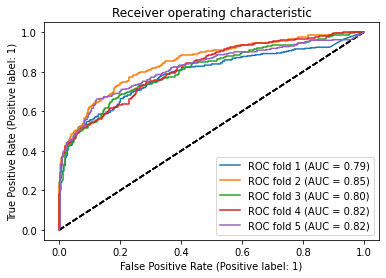

In [7]:
main()

Found 810 validated image filenames belonging to 2 classes.
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68       381
         1.0       0.72      0.73      0.72       429

    accuracy                           0.70       810
   macro avg       0.70      0.70      0.70       810
weighted avg       0.70      0.70      0.70       810

[[257 124]
 [116 313]]


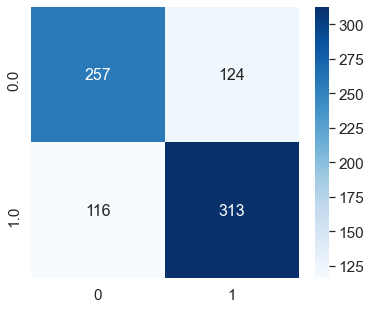

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
test_data = pd.read_csv('dataset_test.csv')
#default label 0 = glaucoma 1 = normal 2 = others
test_data.loc[test_data.label == 2, 'label'] = 0
test_data['label'] = test_data['label'].astype(str)

image_dir = 'dataset_test'

test_generator = ImageDataGenerator(rescale=1./255)

test_data_generator  = test_generator.flow_from_dataframe(test_data, directory = image_dir,
                                                        x_col = 'filename', y_col = 'label',
                                                        target_size = (32, 32),batch_size = 16,
                                                        class_mode = "binary", shuffle = True)

test_data_generator.reset()
        
X_test, y_test = next(test_data_generator)
        
batch_index = 0
while batch_index <= test_data_generator.batch_index:
    img, label = next(test_data_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
    batch_index = batch_index + 1
# CREATE NEW MODEL
model = create_new_model()

# COMPILE NEW MODEL
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])      
model.load_weights("nsaved_models/model_5.h5")
y_pred = model.predict(X_test)
y_pred = np.transpose(y_pred)[0]
y_pred = list(map(lambda x: 0 if x < 0.5 else 1, y_pred))

from sklearn.metrics import classification_report
import seaborn as sn
print(classification_report(y_test, y_pred))

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data,index = np.unique(y_test))
plt.figure(figsize = (6,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt="d")
plt.savefig('Matrix/vgg16_normal_matrix.jpg')

print(data)